In [1]:
%load_ext autoreload
import random
from openff.toolkit.topology import Molecule
import h5py
import numpy as onp
import jax
import jax.numpy as jnp
import jax_md
import espalomax as esp
from concurrent import futures

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [2]:
# from jax import numpy as jnp
# from openff.toolkit.topology import Molecule
# from openff.toolkit.typing.engines.smirnoff import ForceField
# smiles = "CC"
# molecule = Molecule.from_smiles(smiles)
# molecule.assign_partial_charges("zeros")
# forcefield = ForceField("openff_unconstrained-2.0.0.offxml")
# system = forcefield.create_openmm_system(
#     molecule.to_topology(),
#     charge_from_molecules=[molecule],
# )

# from jax_md.mm_utils import parameters_from_openmm_system
# parameters = parameters_from_openmm_system(system)
# molecule.generate_conformers()
# coordinate = molecule.conformers[0]._value * 0.1
# coordinate = jnp.array(coordinate)

# from jax_md import space
# displacement_fn, shift_fn = space.free()

# from jax_md.mm import mm_energy_fn
# energy_fn, _ = mm_energy_fn(
#     displacement_fn, default_mm_parameters=parameters,
# )

# u = energy_fn(coordinate)

In [3]:
# from jax_md import simulate
# temperature = 1.0
# dt = 1e-3
# init, update = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, temperature)
# state = init(jax.random.PRNGKey(2666), coordinate)
# update = jax.jit(update)

In [4]:
# traj = []
# for _ in range(1000):
#     state = update(state)
#     traj.append(state.position)
# traj = jnp.stack(traj)

In [5]:
smiles = "N#N"
molecule = Molecule.from_smiles(smiles)
traj = onp.zeros((100, 2, 3))
traj[:, -1, 0] = onp.random.uniform(0.3, 0.7, size=(len(traj), ))
traj = jnp.array(traj)

In [6]:
u = 2.0 * (traj[:, -1, 0] - 0.5) ** 2

In [7]:
# from openmm import unit
# for _traj in traj:
#     molecule.add_conformer(_traj * unit.nanometer)

In [8]:
model = esp.nn.Parametrization(
    representation=esp.nn.GraphAttentionNetwork(128, 3),
    janossy_pooling=esp.nn.JanossyPooling(128, 4),
)

In [9]:
g = esp.Graph.from_openff_molecule(molecule)

/Users/wangy1/Documents/GitHub/espalomax/espalomax/openff_utils.py:66: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(molecule.to_networkx()).todense()
/Users/wangy1/Documents/GitHub/espalomax/espalomax/openff_utils.py:81: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(molecule.to_networkx()).todense()


In [10]:
def get_loss(nn_params, g, x, u):
    ff_params = model.apply(nn_params, g)
    u_hat = esp.mm.get_energy(ff_params, x, terms=["bond"])
    u_hat = u_hat - u_hat.mean()
    u = u - u.mean()
    return ((u - u_hat) ** 2).mean()

# @jax.jit
def step(state, g, x, u):
    nn_params = state.params
    grads = jax.grad(get_loss)(nn_params, g, x, u)
    state = state.apply_gradients(grads=grads)
    return state

import optax
optimizer = optax.chain(
    optax.additive_weight_decay(1e-5),
    optax.adam(learning_rate=1e-5),
)

nn_params = model.init(jax.random.PRNGKey(2667), g)
from flax.training.train_state import TrainState
from flax.training.checkpoints import save_checkpoint
state = TrainState.create(
     apply_fn=model.apply, params=nn_params, tx=optimizer,
)

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


In [11]:
import tqdm
import random
ks = []
for idx_batch in range(10000):
        # key = (g.n_atoms, g.n_bonds, g.n_angles, g.n_propers, g.n_impropers, x.shape[0])
        # state = compiled[key](state, g, x, u)
        state = step(state, g, traj, u)
        ff_params = model.apply(state.params, g)
        ks.append(ff_params["bond"]["coefficients"][0, 0].item())
        u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


KeyboardInterrupt: 

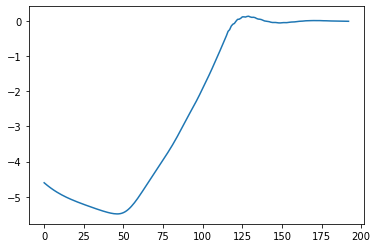

In [21]:
from matplotlib import pyplot as plt
plt.plot(ks)

In [13]:
from sklearn.metrics import r2_score
r2_score(u - u.mean(), u_hat - u_hat.mean())

0.9999617359807164

In [14]:
jnp.abs((u - u.mean()) - (u_hat - u_hat.mean()))

DeviceArray([1.16765499e-04, 1.02255493e-04, 1.60114840e-04,
             8.10623169e-05, 1.55510381e-04, 1.51544809e-04,
             1.50799751e-04, 4.17985022e-04, 3.53902578e-05,
             1.10827386e-04, 1.61327422e-04, 1.59814954e-04,
             1.68189406e-04, 1.41032040e-04, 5.42663038e-05,
             1.00173056e-05, 8.47633928e-05, 1.56709924e-04,
             1.62107870e-04, 6.47120178e-05, 1.53411180e-04,
             1.20352954e-04, 1.26783736e-04, 1.50769949e-04,
             1.80959702e-04, 1.58406794e-04, 7.83335418e-05,
             5.28171659e-05, 4.90397215e-05, 1.15860254e-04,
             1.61256641e-04, 5.30462712e-05, 1.60725787e-04,
             1.32042915e-04, 1.51101500e-04, 9.12696123e-07,
             1.69798732e-04, 2.80726701e-04, 1.27593055e-04,
             1.08424574e-04, 1.62385404e-04, 1.12198293e-04,
             1.38390809e-04, 5.76768070e-05, 1.38469040e-04,
             7.13579357e-05, 1.32549554e-04, 3.72640789e-04,
             3.43315303e

In [15]:
ff_params = model.apply(state.params, g)
u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])

/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/wangy1/miniconda3/envs/espalomax/lib/python3.10/site-packages/flax/core/scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)


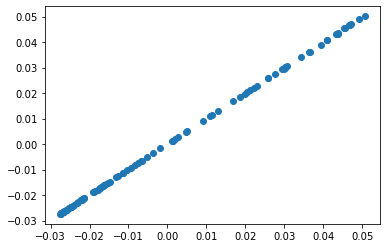

In [17]:
from matplotlib import pyplot as plt
plt.scatter(u - u.mean(), u_hat - u_hat.mean())

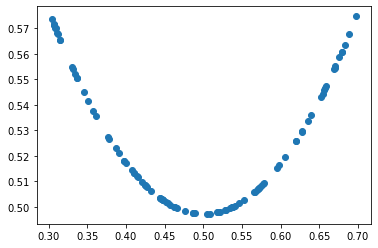

In [18]:
from matplotlib import pyplot as plt
u_hat = esp.mm.get_energy(ff_params, traj, terms=["bond"])
plt.scatter(traj[:, -1, 0], u_hat)

In [19]:
ff_params["bond"]["coefficients"] = jnp.zeros_like(ff_params["bond"]["coefficients"])

In [20]:
ff_params["bond"]["coefficients"]

DeviceArray([[0., 0.]], dtype=float32)